## Awesome Italia Remote

In [1]:
%%bash
# download the data and delete everything else
#rm -rf ./data
#git clone --depth=1 https://github.com/italiaremote/awesome-italia-remote.git
#mv awesome-italia-remote/data ./data
#rm -rf awesome-italia-remote

In [2]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
plt.xkcd(scale=0.5)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ['xkcd Script', 'xkcd']

## Loading the data

In [3]:
data_dir = "./data"
json_files = os.listdir(path=data_dir)

In [4]:
companies_list = []
for jf in json_files:
    with open(os.path.join(data_dir, jf)) as jfp:
        companies_list.append(json.load(jfp))

In [5]:
companies_df = pd.DataFrame(companies_list)

## What does the data look like?

**What do we know about each company?**

In [6]:
companies_df.head(3)

,name,url,career_page_url,type,categories,remote_policy,hiring_policies,tags
0,TheFork,https://www.thefork.com/,https://careers.thefork.com/global/en,Product,[cloud_software],Hybrid,[Direct],"[Node.js, React, TypeScript, GraphQL, Kotlin, ..."
1,20tab,https://www.20tab.com/,https://www.20tab.com/connect/careers,Consulting,[cloud_software],Full,[Direct],"[AWS, DevOps, Docker, Django, Firebase, Flutte..."
2,Mollie,https://www.mollie.com/,https://jobs.mollie.com/,Product,[cloud_software],Optional,[Direct],"[PHP, Java, GCP, Data Analysis, Data Science]"


**How is that knowledge stored?**

In [7]:
types_df = pd.DataFrame({
    "columns": companies_df.columns, # column names are easy
    # get the type from the first element in each column
    "type": [type(companies_df.loc[0, cn]).__name__ for cn in companies_df.columns]
})
types_df.insert(
    loc=len(types_df.columns),
    column="inner_type",
    value=[type(companies_df.loc[0, row[1].columns][0]).__name__ if row[1].type=="list" else "-" for row in types_df.iterrows()]
)

In [8]:
print(types_df.to_markdown())

|    | columns         | type   | inner_type   |
|---:|:----------------|:-------|:-------------|
|  0 | name            | str    | -            |
|  1 | url             | str    | -            |
|  2 | career_page_url | str    | -            |
|  3 | type            | str    | -            |
|  4 | categories      | list   | str          |
|  5 | remote_policy   | str    | -            |
|  6 | hiring_policies | list   | str          |
|  7 | tags            | list   | str          |


**How many companies are there in the dataset?**

In [9]:
print(companies_df.loc[:, ["name", "career_page_url"]].describe().to_markdown())

|        | name       | career_page_url                    |
|:-------|:-----------|:-----------------------------------|
| count  | 340        | 340                                |
| unique | 339        | 338                                |
| top    | Fifth Beat | https://www.sorint.com/en/careers/ |
| freq   | 2          | 2                                  |


Looks like there is one duplicate entry among the 340 companies in the dataset.  
For the 'name' column there is an entry with frequency 2. Let's see what's going on with "Fifth Beat".

In [10]:
companies_df.loc[companies_df.name=="Fifth Beat"]

,name,url,career_page_url,type,categories,remote_policy,hiring_policies,tags
69,Fifth Beat,https://www.fastloop.it/,https://www.fastloop.it/careers/,Consulting,"[design_ux, cloud_software]",Full,"[Direct, Contract]","[Business Analyst, Content Design, AWS, Javasc..."
125,Fifth Beat,https://fifthbeat.com/,https://fifthbeat.com/contacts,Consulting,"[design_ux, cloud_software]",Optional,"[Direct, Contract]","[Business Analyst, Content Design, AWS, Javasc..."


Based on the values on the other details for these two occurrences of 'Fifth Beat' it looks like one of the two should be called 'Fastloop' instead.  
Let's fix this little error.

In [11]:
companies_df.loc[69, "name"] = "Fastloop"

In [12]:
companies_df.loc[[69,125]]

,name,url,career_page_url,type,categories,remote_policy,hiring_policies,tags
69,Fastloop,https://www.fastloop.it/,https://www.fastloop.it/careers/,Consulting,"[design_ux, cloud_software]",Full,"[Direct, Contract]","[Business Analyst, Content Design, AWS, Javasc..."
125,Fifth Beat,https://fifthbeat.com/,https://fifthbeat.com/contacts,Consulting,"[design_ux, cloud_software]",Optional,"[Direct, Contract]","[Business Analyst, Content Design, AWS, Javasc..."


There are also other fields that should logically only contain unique values.  
**Are there other duplicate values that shouldn't be?**

In [13]:
companies_df.describe().loc[:, ["url", "career_page_url"]]

,url,career_page_url
count,340,340
unique,340,338
top,https://www.thefork.com/,https://www.sorint.com/en/careers/
freq,1,2


While the url column presents 340 unique values the career_page_url only has 338 for the 340 entries. This means that there must be 2 values occurring more than once.

In [14]:
cpu_df = companies_df.loc[:, ["career_page_url"]]

In [15]:
print(companies_df.loc[cpu_df.duplicated(keep=False), ["name", "url", "career_page_url"]].to_markdown())

|     | name                      | url                        | career_page_url                    |
|----:|:--------------------------|:---------------------------|:-----------------------------------|
| 146 | HACKERSGEN                | https://hackersgen.com     | https://www.sorint.com/en/careers/ |
| 148 | Docplanner                | https://www.docplanner.com | https://www.docplanner.com/career  |
| 155 | SORINT.lab                | https://www.sorint.com/en/ | https://www.sorint.com/en/careers/ |
| 225 | Gipo - Ianiri Informatica | https://www.gipo.it        | https://www.docplanner.com/career  |


This shows that HACKERSGEN and SORINT.lab share the same career_page_url and the same goes for Docplanner and Gipo - Ianiri Informatica.  
Looking at the websites from HACKERSGEN and SORINT.lab they actually link to the same page for their career section, so these companies are in some sort of relationship and this duplicated value is **not an error**.  
The same goes when looking at Docplanner and Gipo. There is **no error** here too.

## Some Stats and Graphs
We already know there are 340 unique companies as of today. Let's dive deeper into the data.  

**Which company types do we have?**

In [16]:
type_vcounts = companies_df.type.value_counts(dropna=False)

In [17]:
def plot_freq_and_prop(vcounts, title, textleft=1.05):

    vcounts.index = ["Unknown" if type(i) != str and np.isnan(i) else i for i in vcounts.index]

    # even when counting things like tags (with multiple tags
    # per company) we still want
    # to know the proportion with respect to total companies
    # and not total tag occurrences
    tot_counts = len(companies_df)
    props = vcounts / tot_counts
    
    fig, ax1 = plt.subplots()
    ax1.set_ylabel('frequencies')
    ax2 = ax1.twinx()
    ax2.set_ylabel('proportions')
    ax2.set_ylim(0, props.max()+(10/tot_counts))
    
    ax1.bar(x=vcounts.index, height=vcounts, zorder=3)
    plt.title(title)
    ax1.grid(visible=True, axis="y", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
    ax1.set_xticks(vcounts.index)
    ax1.set_xticklabels(vcounts.index, rotation=45)

    side_text = ""
    for k in vcounts.index:
        this_line = f"{k[:16]} / "
        this_line += f"{vcounts[k]} / "
        this_line += f"{props[k]:.2f}\n"
        side_text += this_line
    
    fig.text(textleft, 0.88, side_text, verticalalignment="top", fontsize=12)
    
    plt.show()

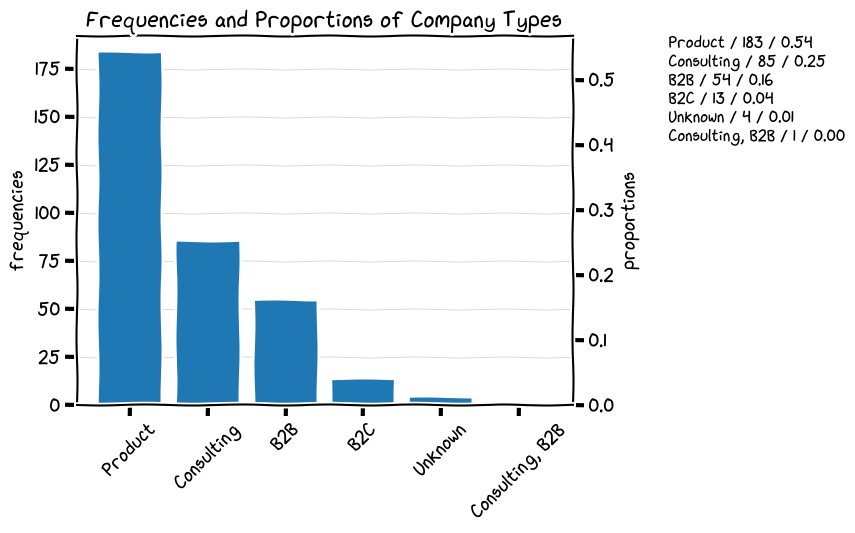

In [18]:
plot_freq_and_prop(type_vcounts, "Frequencies and Proportions of Company Types")

**Which remote work policies do these companies apply?**

In [19]:
policy_vcounts = companies_df.remote_policy.value_counts(dropna=False)

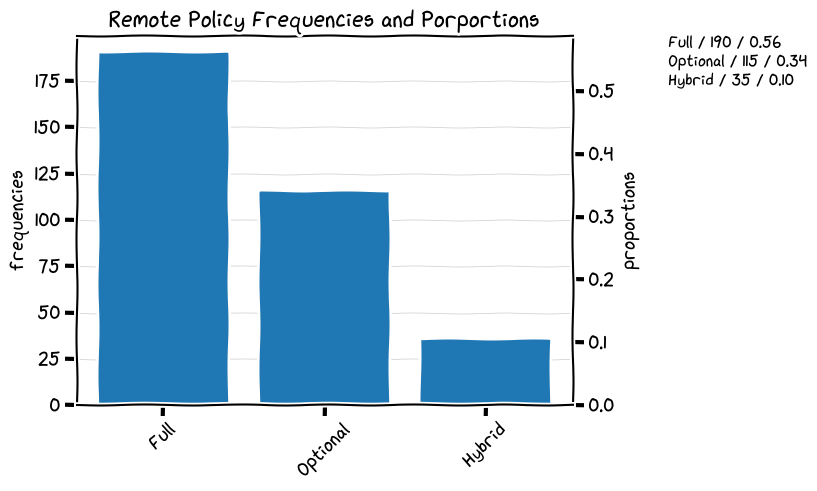

In [20]:
plot_freq_and_prop(policy_vcounts, "Remote Policy Frequencies and Porportions")

**Which technologies are used in these companies?**  
There is quite some enthropy in the "tags" column. Lots of technolgies have more than one tag because of formatting (i.e. "VMWare" vs "VMware") or even because of different styling (i.e. "Unity 3D" vs "Unity3D").  
Fist we need to put some order if we want to describe the data meaningfully.

In [21]:
# Some of the values might not even be lists
for taglist in companies_df.tags:
    if type(taglist) != list:
        print(taglist, end=" ")

nan nan nan nan nan nan nan 

In [22]:
# fixing nan values
num_of_na_values = companies_df.tags.isna().sum()
companies_df.loc[companies_df.tags.isna(), "tags"] = [["unknown"]]*num_of_na_values

There is also quite a number of companies in which the absence of tags is represented as a list containing only the "-" string. Let's replace that too.

In [23]:
# replacing ["-"] with ["unknown"]
num_of_dash_tags = companies_df.loc[:, ["tags"]].map(lambda tl: tl==["-"]).tags.sum()
companies_df.loc[companies_df.loc[:, ["tags"]].map(lambda tl: tl==["-"]).tags, "tags"] = [["unknown"]]*num_of_dash_tags

How many unique tags do we have at this point?

In [24]:
unique_tags = set()
for tagslist in companies_df.tags:
    if type(tagslist) == list:
        unique_tags.update(tagslist)
print(f"We have {len(unique_tags)} unique tags.")

We have 461 unique tags.


Now for the styling problems it would be ideal to build a mapping (an hash map, dict or whatever) between different versions of the same tag and a single version that we want to keep in our final dataset.  
461 tags are not that many tags to go through by hands to build our dictionary, but being that we are in 2024 this might just be the perfect job to delegate to an LLM chatbot.  
I fed the full list of unique tags to a famous LLM chatbot and after fiddling a bit with prompts to convince it to give me the desired output and finally came up with a dict that looks like this:

In [25]:
from tags_repl import tags_replacement

In [26]:
for k in list(tags_replacement.keys())[4:11]:
    print(f"{k} -> {tags_replacement[k]}")

AI -> AI/ML
AI/ML -> AI/ML
API Integrations -> API Integrations
AR (Augmented Reality) -> AR (Augmented Reality)
ASP.NET Core -> ASP.NET Core
AWS -> AWS
AWS Cloud -> AWS


It is not completely perfect but most inconsistencies and duplicates are solved. Just a fast test to be sure nothing is missing...

In [27]:
print("Any tags coming from hallucinations?")
for t in tags_replacement.keys():
    if t not in unique_tags:
        print(t)

Any tags coming from hallucinations?


In [28]:
print("Any tags disappeared in the process?")
keys_repl = set(tags_replacement.keys())
for t in unique_tags:
    if t not in keys_repl:
        print(t)

Any tags disappeared in the process?


... and looks like we are good to go.

In [29]:
def replace_tags(tl: list[str]):
    return [tags_replacement[t] for t in tl]

companies_df.tags = companies_df.loc[:, "tags"].map(replace_tags)

There is still a minor annoyance: some tags are "composite" like "JavaScript/TypeScript" or "Node.js/React". In some cases they make sense but other times we want to split them.

In [30]:
tags_to_split = [
    "Java/Maven", "Elixir/Erlang", "JavaScript/TypeScript", "Node.js/React", "C#/.NET"
]
def split_composite_tags(tl: list[str]):
    new_tl = []
    for t in tl:
        if t in tags_to_split:
            new_tl.extend(t.split("/"))
        else:
            new_tl.append(t)
    return new_tl

companies_df.tags = companies_df.tags.map(split_composite_tags)

In [31]:
# update the unique tags list:
unique_tags = set()
for tagslist in companies_df.tags:
    if type(tagslist) == list:
        unique_tags.update(tagslist)
print(f"We have {len(unique_tags)} unique tags.")

We have 365 unique tags.


Let's try to visualize **the most requested technolgies and skills** from companies hiring Italian developers remotely.

In [32]:
tag_counts = {}
for t in unique_tags:
    tag_counts[t] = companies_df.tags.map(lambda tl: t in tl).sum()

In [33]:
tags_counts_df = pd.DataFrame.from_dict(tag_counts, orient="index", columns=["count"])

In [34]:
tags_counts_df.sort_values(by="count", ascending=False, inplace=True)

In [35]:
tags_counts_df.insert(
    loc=len(tags_counts_df.columns),
    column="proportion",
    value=tags_counts_df.loc[:, "count"]/len(companies_df)
)

In [36]:
from wordcloud import WordCloud

(-0.5, 899.5, 899.5, -0.5)

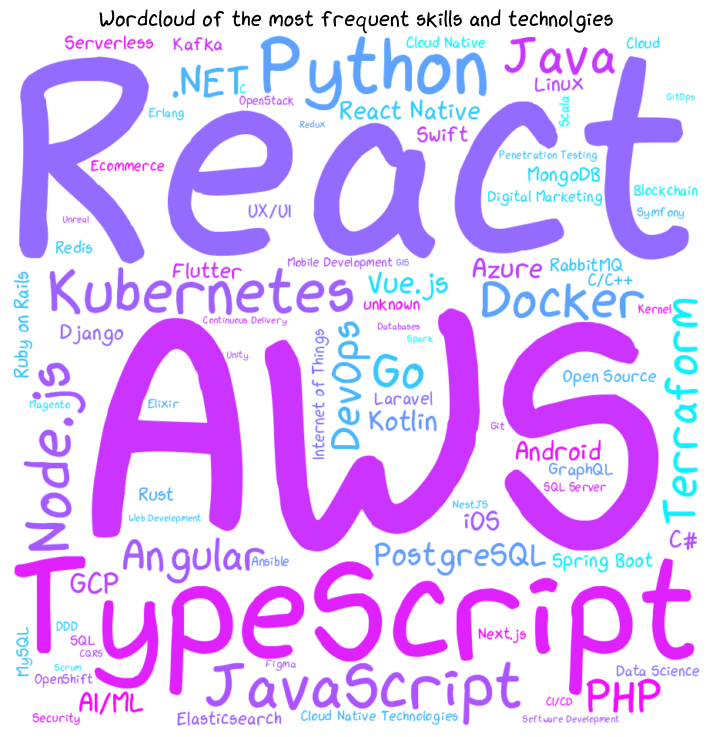

In [37]:
height = 900
width = 900
my_dpi = 96
wc = WordCloud(width=width, height=height, min_font_size=12, background_color="white", colormap="cool", font_path="xkcd-script.ttf", max_words=500
).generate_from_frequencies(tag_counts)
plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation="bilinear")
plt.title("Wordcloud of the most frequent skills and technolgies")
plt.axis("off")

Text(0.5, 1.0, "Top 25 tech/skills appearing in companies' tags")

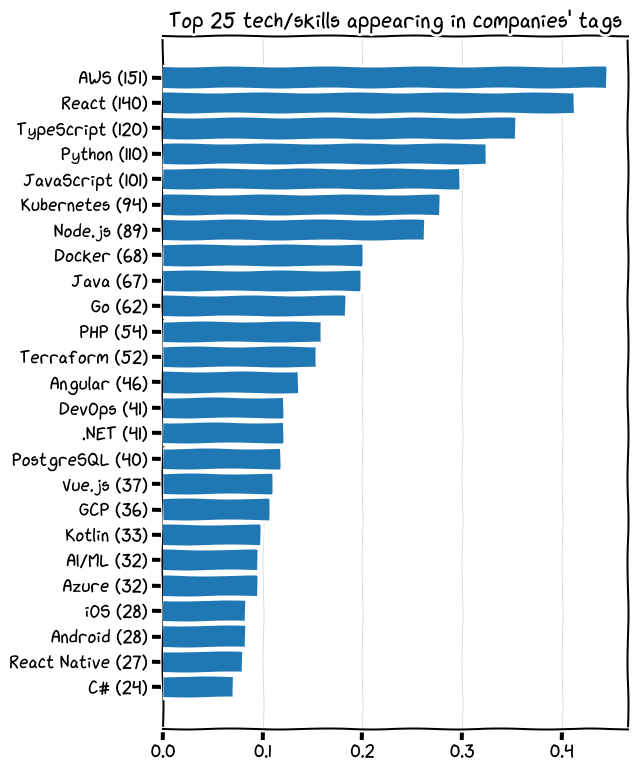

In [38]:
temp_df = tags_counts_df.sort_values(by="proportion").tail(25)
plt.figure(figsize=(600/my_dpi, 900/my_dpi), dpi=my_dpi)
y_labels = [f"{t} ({c})" for t,c in zip(temp_df.index, temp_df.loc[:, "count"])]
plt.barh(width=temp_df.loc[:, "proportion"], y=y_labels, zorder=3)
plt.grid(visible=True, axis="x", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
plt.title("Top 25 tech/skills appearing in companies' tags")

The following tags have only 1 occurrence.

In [39]:
tags_with_one_occurrence = list(tags_counts_df.loc[tags_counts_df["count"]==1].index)
tags_with_one_occurrence = sorted(tags_with_one_occurrence)
cols = [[]]
c, tinc = 0, 0
for t in tags_with_one_occurrence:
    if tinc==30:
        cols.append([])
        tinc=0
        c+=1
    cols[c].append(t)
    tinc+=1

# fill the last column to be the same length as the others
for i in range(len(cols[-1]), len(cols[-2])):
    cols[-1].append("")

In [40]:
print(f"The following {len(tags_with_one_occurrence)} tags only appear once:")
for row in zip(*cols):
    print(("{:<28}"*len(cols)).format(*row))

The following 201 tags only appear once:
.NET Core 5                 CPaaS                       ESP32                       IT Managed Services         Multimedia                  Rancher                     Tomcat                      
3D                          CRM                         EdTech                      Identity                    Nakama                      Remix                       Training                    
ACSIA                       CSS                         Elastic                     Inclusive content           Native Mobile Development   SAML                        TrinoDB                     
API Integrations            Cassandra                   Elm                         Influencer Marketing        NativeScript                SEM                         Troubleshooting             
AR (Augmented Reality)      Clean Architecture          EmberJS                     Information architecture    Navision                    SEO                         VR 

**In which categories do the companies fall?**

In [41]:
all_categories_mentions = []
for cl in companies_df.categories:
    if len(cl)==0:
        all_categories_mentions.append("unknown")
    all_categories_mentions.extend(cl)

In [42]:
len(all_categories_mentions)

412

In [43]:
len(all_categories_mentions)/len(companies_df)

1.2117647058823529

In [44]:
unique_categories = set(all_categories_mentions)

In [45]:
unique_categories

{'cloud_software', 'cybersecurity', 'design_ux', 'hr', 'marketing_writing'}

In [46]:
categories_counts = {}
for c in unique_categories:
    categories_counts[c] = 0
    for cm in all_categories_mentions:
        if cm==c:
            categories_counts[c]+=1

categories_counts_df = pd.DataFrame.from_dict(categories_counts, orient="index", columns=["count"])
categories_counts_df.insert(
    loc=len(categories_counts_df.columns),
    column="proportion",
    value=categories_counts_df.loc[:, "count"]/len(companies_df)
)

In [47]:
print(categories_counts_df.to_markdown())

|                   |   count |   proportion |
|:------------------|--------:|-------------:|
| cloud_software    |     298 |    0.876471  |
| hr                |      12 |    0.0352941 |
| design_ux         |      45 |    0.132353  |
| cybersecurity     |      12 |    0.0352941 |
| marketing_writing |      45 |    0.132353  |


Text(0.5, 1.0, 'Distribution of categories among companies')

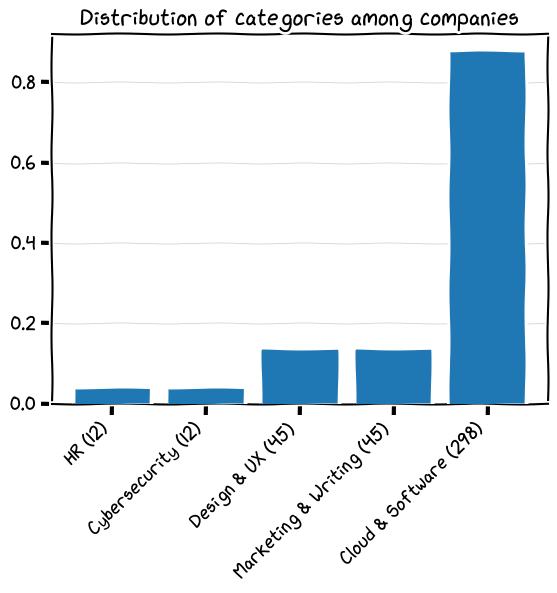

In [48]:
temp_df = categories_counts_df.sort_values(by="proportion")
x_pretty = {
    "hr": "HR",
    "cybersecurity": "Cybersecurity",
    "marketing_writing": "Marketing & Writing",
    "design_ux": "Design & UX",
    "cloud_software": "Cloud & Software"
}
x_labels = [f"{x_pretty[t]} ({c})" for t,c in zip(temp_df.index, temp_df.loc[:, "count"])]
fig, ax1 = plt.subplots()
ax1.bar(height=temp_df.loc[:, "proportion"], x=x_labels, zorder=3)
ax1.set_xticks(range(len(temp_df.index)))
ax1.set_xticklabels(x_labels, rotation=45, fontdict={"horizontalalignment": "right"})
ax1.grid(visible=True, axis="y", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
plt.title("Distribution of categories among companies")

**What is the distribution of hiring policies?**

In [49]:
# replacing ["-"] with ["unknown"]
#dash_hp_df = companies_df.loc[:, ["hiring_policies"]].map(lambda tl: tl==["-"])
#num_of_dash_hp = len(dash_hp_df.loc[dash_hp_df.hiring_policies==True])
#companies_df.loc[dash_hp_df.hiring_policies, "hiring_policies"] = [["unknown"]]*num_of_dash_hp
# Something weird is happening here:
# this is the same exact replacement used for tags but when done for hiring_policies
# it keeps replacing with "unknown" instead of ["unkown"]. Trying to reproduce the same
# behavior in 'casting_weirdness.ipynb' ended up not reproducing the behavior and instead
# working just as expected. The same exact code copied in this cell did not give the right result.
#
# companies_df.hiring_policies

In [50]:
all_hp_mentions = []
for hpl in companies_df.hiring_policies:
    all_hp_mentions.extend(hpl)

In [51]:
len(all_hp_mentions)

358

In [52]:
len(all_hp_mentions)/len(companies_df)

1.0529411764705883

In [53]:
unique_hp = set(all_hp_mentions)

In [54]:
unique_hp

{'-', 'Contract', 'Direct', 'Intermediary'}

In [55]:
hp_counts = {}
for hp in unique_hp:
    hp_counts[hp] = 0
    for hpm in all_hp_mentions:
        if hpm==hp:
            hp_counts[hp]+=1

hp_counts_df = pd.DataFrame.from_dict(hp_counts, orient="index", columns=["count"])
hp_counts_df.insert(
    loc=len(hp_counts_df.columns),
    column="proportion",
    value=hp_counts_df.loc[:, "count"]/len(companies_df)
)
hp_counts_df.index = ["unknown" if i=="-" else i for i in hp_counts_df.index]

In [56]:
print(hp_counts_df.to_markdown())

|              |   count |   proportion |
|:-------------|--------:|-------------:|
| Contract     |      55 |    0.161765  |
| Direct       |     254 |    0.747059  |
| Intermediary |      12 |    0.0352941 |
| unknown      |      37 |    0.108824  |


Text(0.5, 1.0, 'Distribution of hiring policies among companies')

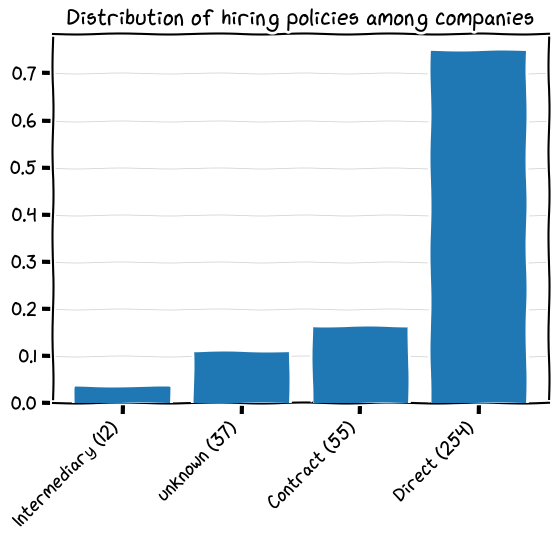

In [57]:
temp_df = hp_counts_df.sort_values(by="proportion")
x_labels = [f"{t} ({c})" for t,c in zip(temp_df.index, temp_df.loc[:, "count"])]
fig, ax1 = plt.subplots()
ax1.bar(height=temp_df.loc[:, "proportion"], x=x_labels, zorder=3)
ax1.set_xticks(range(len(temp_df.index)))
ax1.set_xticklabels(x_labels, rotation=45, fontdict={"horizontalalignment": "right"})
ax1.grid(visible=True, axis="y", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
plt.title("Distribution of hiring policies among companies")

### Exploding list variables
In order to analyze the cooccurrence of type, categories, tags, hiring_policies I'm going to build an expanded version of the companies dataframe in which fields cotaining lists are transformed to singular categorical values by repeating the entry for each of the values in the original list.

In [58]:
# Only working with name, type, categories, remote_policy, hiring_policies and tags
exp_companies_df = companies_df.loc[:, ["name", "type", "categories", "remote_policy", "hiring_policies", "tags"]].copy()
exp_companies_df.head()

,name,type,categories,remote_policy,hiring_policies,tags
0,TheFork,Product,[cloud_software],Hybrid,[Direct],"[Node.js, React, TypeScript, GraphQL, Kotlin, ..."
1,20tab,Consulting,[cloud_software],Full,[Direct],"[AWS, DevOps, Docker, Django, Firebase, Flutte..."
2,Mollie,Product,[cloud_software],Optional,[Direct],"[PHP, Java, GCP, Data Analysis, Data Science]"
3,Primer,Product,[cloud_software],Full,[-],"[JavaScript, TypeScript, React, Python, AWS, D..."
4,Loop Srl,B2B,[marketing_writing],Full,[Contract],"[Ecommerce, Social Media Management]"


In [59]:
for col in ["categories", "hiring_policies", "tags"]:
    exp_companies_df = exp_companies_df.explode(column=col, ignore_index=True)

In [60]:
exp_companies_df.loc[exp_companies_df.hiring_policies=="-", "hiring_policies"] = "unknown"

In [61]:
exp_companies_df

,name,type,categories,remote_policy,hiring_policies,tags
0,TheFork,Product,cloud_software,Hybrid,Direct,Node.js
1,TheFork,Product,cloud_software,Hybrid,Direct,React
2,TheFork,Product,cloud_software,Hybrid,Direct,TypeScript
3,TheFork,Product,cloud_software,Hybrid,Direct,GraphQL
4,TheFork,Product,cloud_software,Hybrid,Direct,Kotlin
...,...,...,...,...,...,...
3653,Codezen,Consulting,cybersecurity,Full,Direct,Go
3654,Codezen,Consulting,cybersecurity,Full,Direct,Solidity
3655,Codezen,Consulting,cybersecurity,Full,Direct,Blockchain
3656,Codezen,Consulting,cybersecurity,Full,Direct,Cryptography


### Do companies with more than one category tend to appear more or less in a specific category?

I want to build a correlation matrix between the 'categories' and wether the companies in those categories also fall in other categories. To do so I want to restrict the dataframe to only those variables and remove all the duplicates as in the current form the number of tags and hiring policies would influence the result.

In [62]:
cat_ncat_df = exp_companies_df.loc[:, ["name", "categories"]]
print(len(cat_ncat_df))
cat_ncat_df = cat_ncat_df.drop_duplicates()
print(len(cat_ncat_df))

3658
412


In [63]:
cat_ncat_df.head()

,name,categories
0,TheFork,cloud_software
7,20tab,cloud_software
21,Mollie,cloud_software
26,Primer,cloud_software
32,Loop Srl,marketing_writing


In [64]:
def get_n_of_cats(company_name):
    return len(companies_df.loc[companies_df.name==company_name].iloc[0].categories) > 1

In [65]:
cat_ncat_df.insert(
    loc=len(cat_ncat_df.columns),
    column="has_2_or_more",
    value=cat_ncat_df.name.map(get_n_of_cats)
)

In [66]:
cat_ncat_df.sample(5)

,name,categories,has_2_or_more
390,iubenda,cloud_software,False
3605,Mamacrowd,cloud_software,False
1260,Fifth Beat,design_ux,True
2463,Cardo AI,cloud_software,False
3542,storyteq,cloud_software,False


In [67]:
cat_ncat_df.describe()

,name,categories,has_2_or_more
count,412,412,412
unique,340,5,2
top,Luna Labs Srl,cloud_software,False
freq,5,298,288


In [68]:
contingency_cat_ncat = pd.crosstab(cat_ncat_df.categories, cat_ncat_df.has_2_or_more)

In [69]:
print(contingency_cat_ncat.to_markdown())

| categories        |   False |   True |
|:------------------|--------:|-------:|
| cloud_software    |     249 |     49 |
| cybersecurity     |       4 |      8 |
| design_ux         |       5 |     40 |
| hr                |       2 |     10 |
| marketing_writing |      28 |     17 |


The vertical sums will not add up to the number of companies as the table does not describe companies vs "multicategoricity" but category occurrences vs "multicategoricity".

In [70]:
from scipy.stats import chi2_contingency

In [71]:
chi2_test_res = chi2_contingency(contingency_cat_ncat.values)

In [72]:
chi2_test_res

Chi2ContingencyResult(statistic=125.39297603965372, pvalue=3.7616354613201274e-26, dof=4, expected_freq=array([[208.31067961,  89.68932039],
       [  8.38834951,   3.61165049],
       [ 31.45631068,  13.54368932],
       [  8.38834951,   3.61165049],
       [ 31.45631068,  13.54368932]]))

In [73]:
chi2_test_res.pvalue

3.7616354613201274e-26

<Axes: title={'center': "Contingency matrix\nof company's category\nand presence in 2 or more"}, xlabel='has_2_or_more', ylabel='categories'>

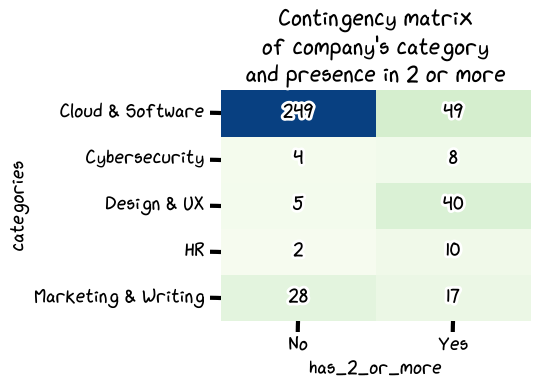

In [74]:
plt.figure(figsize=(4,3))
plt.title("Contingency matrix\nof company's category\nand presence in 2 or more")
ylabs = [x_pretty[l] for l in contingency_cat_ncat.index]
sns.heatmap(contingency_cat_ncat, annot=True, fmt="d", annot_kws={"color":"#000"}, cmap="GnBu", yticklabels=ylabs, xticklabels=["No", "Yes"], vmin=0, vmax=249, cbar=False)

In [75]:
contingency_cat_ncat.columns

Index([False, True], dtype='bool', name='has_2_or_more')

In [76]:
chi2_test_res.expected_freq

array([[208.31067961,  89.68932039],
       [  8.38834951,   3.61165049],
       [ 31.45631068,  13.54368932],
       [  8.38834951,   3.61165049],
       [ 31.45631068,  13.54368932]])

Text(0.5, 1.0, 'Expected Frequencies')

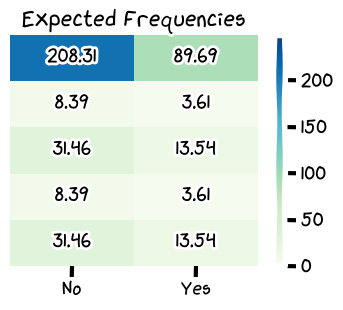

In [77]:
plt.figure(figsize=(4,3))
sns.heatmap(chi2_test_res.expected_freq, fmt=".2f", yticklabels=False, annot=True, annot_kws={"color":"#000"}, cmap="GnBu", xticklabels=["No", "Yes"], vmin=0, vmax=249)
plt.title("Expected Frequencies")

I could either put this chart on the right side of the contingency matrix to show the difference or calculate the proportions of companies in each category that have more than one category and add it as a new column. Or I could do both.

In [78]:
def find_prop_and_deviation(n_one_cat, n_multi_cat, expected_prop):
    """
    Calculate the proportion of the second variable (Yes/True)
    and how much it deviates from the expected proportion.
    """
    prop = n_multi_cat / (n_multi_cat+n_one_cat)
    deviation = prop - expected_prop
    return prop, deviation

In [79]:
expected_prop = chi2_test_res.expected_freq[0,1] / (chi2_test_res.expected_freq[0,1]+chi2_test_res.expected_freq[0,0])
prop_and_deviation = []
for row in contingency_cat_ncat.itertuples(index=True, name=None):
    prop_and_deviation.append([row[0], *find_prop_and_deviation(row[1], row[2], expected_prop)])

In [80]:
prop_and_deviation = np.array(prop_and_deviation)

In [81]:
prop_and_deviation = pd.DataFrame(data=prop_and_deviation[:,1:],
                                  columns=["prop_has_multi_cat", "displ_from_expected"],
                                  index=prop_and_deviation[:,0]
                                 )

In [82]:
expected_prop

0.30097087378640774

In [83]:
prop_and_deviation = prop_and_deviation.astype(dtype=np.float64)
prop_and_deviation

,prop_has_multi_cat,displ_from_expected
cloud_software,0.164430,-0.136541
cybersecurity,0.666667,0.365696
design_ux,0.888889,0.587918
hr,0.833333,0.532362
marketing_writing,0.377778,0.076807


Text(0.5, 1.0, 'Displacement from expected\nproportion of companies\nwith more than one category')

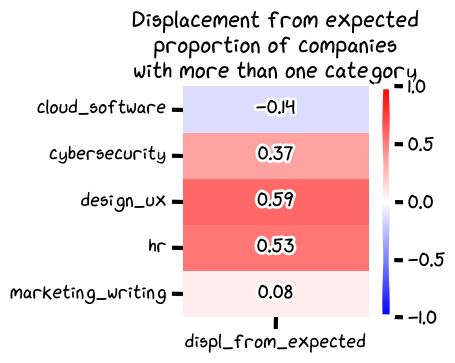

In [84]:
plt.figure(figsize=(3,3))
sns.heatmap(prop_and_deviation.loc[:, ["displ_from_expected"]], fmt=".2f", annot=True, annot_kws={"color":"#000"}, cmap="bwr", vmin=-1, vmax=1)
plt.title("Displacement from expected\nproportion of companies\nwith more than one category")

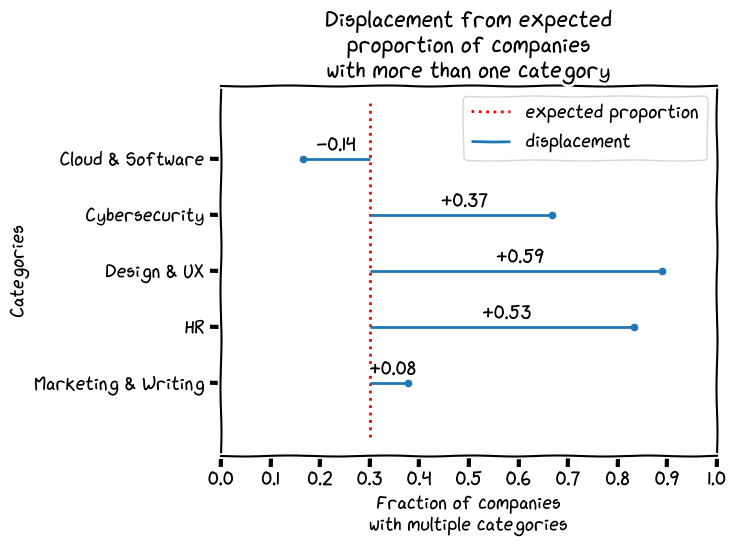

In [85]:
prop_and_deviation.index = [x_pretty[l] for l in prop_and_deviation.index]
sns.scatterplot(
    y=prop_and_deviation.index,
    x=(prop_and_deviation.prop_has_multi_cat)
)
plt.vlines(x=expected_prop, ymin=-1, ymax=5, label="expected proportion", colors='red', linestyles="dotted")
plt.title("Displacement from expected\nproportion of companies\nwith more than one category")
plt.xlim((0, 1))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Categories")
plt.xlabel("Fraction of companies\nwith multiple categories")
plt.hlines(
    y=prop_and_deviation.index,
    xmin=prop_and_deviation.prop_has_multi_cat,
    xmax=[expected_prop]*len(prop_and_deviation),
    label="displacement"
)
i=-0.15
for row in prop_and_deviation.itertuples(name=None):
    plt.text(x=(row[1]+expected_prop)/2-0.04, y=i, s=f"{row[2]:+.2f}")
    i+=1
plt.legend()

Answer: **There is a significant effect (p-value is extremely close to 0).**  
**Cloud and Software companies have a tendency to only work in cloud and software, while companies in other categories have a tendency to diversify more.**  
It is worth to mention that this might be the result of "Cloud and Software" being a very broad line of work that could be split in lots of sub-categories while the other four are quite well defined.

### Which skills and technologies are more correlated with cybersecurity companies?

I think in this case it's better to keep the categories together for companies with more than one.

In [86]:
exp_tags_join_cats_df = companies_df.loc[:, ["name", "categories", "tags"]]

In [87]:
exp_tags_join_cats_df.categories = ["\n& ".join(sorted(catlist)) for catlist in exp_tags_join_cats_df.categories]

In [88]:
exp_tags_join_cats_df = exp_tags_join_cats_df.explode(column=["tags"])

In [89]:
exp_are_in_cyber_df = exp_tags_join_cats_df.loc[["cybersec" in c for c in exp_tags_join_cats_df.categories]]
print(len(exp_are_in_cyber_df))
exp_are_in_cyber_df.sample(5)

126


,name,categories,tags
314,THE I,cloud_software\n& cybersecurity,Node.js
73,Softlab S.p.A.,cloud_software\n& cybersecurity\n& marketing_w...,AWS
102,Telepass,cloud_software\n& cybersecurity\n& design_ux,Mobile Development
29,Zucchetti S.p.A.,cloud_software\n& cybersecurity,OpenShift
339,Codezen,cybersecurity,Rust


In [90]:
print(exp_are_in_cyber_df.loc[:, "tags"].value_counts(ascending=False).to_markdown())

| tags                      |   count |
|:--------------------------|--------:|
| DevOps                    |       6 |
| Kubernetes                |       5 |
| AWS                       |       4 |
| UX/UI                     |       4 |
| AI/ML                     |       4 |
| Java                      |       4 |
| Vue.js                    |       3 |
| Data Science              |       3 |
| GCP                       |       3 |
| Python                    |       3 |
| Node.js                   |       3 |
| Go                        |       3 |
| Cloud Native              |       3 |
| Azure                     |       3 |
| Penetration Testing       |       3 |
| React                     |       3 |
| Rust                      |       2 |
| Red Teaming               |       2 |
| Hardware Security         |       2 |
| Web Development           |       2 |
| .NET                      |       2 |
| Android                   |       2 |
| iOS                       |       2 |


In [91]:
exp_are_only_in_cyber_df = exp_are_in_cyber_df.loc[exp_are_in_cyber_df.categories=="cybersecurity"]
print(len(exp_are_only_in_cyber_df))
exp_are_only_in_cyber_df.sample(5)

17


,name,categories,tags
332,Infor srl SB,cybersecurity,Hardware Security
333,Shielder,cybersecurity,Hardware Security
339,Codezen,cybersecurity,Blockchain
339,Codezen,cybersecurity,Solidity
332,Infor srl SB,cybersecurity,Vulnerability Assessment


In [92]:
exp_are_only_in_cyber_df.name.unique()

array(['4Securitas', 'Infor srl SB', 'Shielder', 'Codezen'], dtype=object)

In [93]:
print(exp_are_only_in_cyber_df.loc[:, "tags"].value_counts(ascending=False).to_markdown())

| tags                     |   count |
|:-------------------------|--------:|
| Penetration Testing      |       2 |
| Hardware Security        |       2 |
| ACSIA                    |       1 |
| Vulnerability Assessment |       1 |
| IT Managed Services      |       1 |
| Digital Transformation   |       1 |
| Security Research        |       1 |
| Application Security     |       1 |
| Red Teaming              |       1 |
| Rust                     |       1 |
| Go                       |       1 |
| Solidity                 |       1 |
| Blockchain               |       1 |
| Cryptography             |       1 |
| Distributed Systems      |       1 |


I was expecting to find python among these, but then again, there are only 4 companies that only have the 'cybersecurity' category.